<a href="https://colab.research.google.com/github/MTSAHU/MNIST-Neural-Networks-DL/blob/main/AmitSahu_LSTM_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

In [21]:
# Create directory and dummy dataset if not exists
if not os.path.exists("mitbih_dataset"):
    os.makedirs("mitbih_dataset")

train_file_path = 'mitbih_dataset/mitbih_train.csv'
test_file_path = 'mitbih_dataset/mitbih_test.csv'

if not os.path.exists(train_file_path):
    dummy_train_data = np.random.rand(100, 188)
    dummy_train_data[:, -1] = np.random.randint(0, 5, 100)
    np.savetxt(train_file_path, dummy_train_data, delimiter=',')

if not os.path.exists(test_file_path):
    dummy_test_data = np.random.rand(20, 188)
    dummy_test_data[:, -1] = np.random.randint(0, 5, 20)
    np.savetxt(test_file_path, dummy_test_data, delimiter=',')

In [22]:
# Load dataset
df_train = pd.read_csv(train_file_path, header=None)
df_test = pd.read_csv(test_file_path, header=None)
df_combined = pd.concat([df_train, df_test], axis=0)

X = df_combined.iloc[:, :-1].values
y = df_combined.iloc[:, -1].values

In [23]:
# Normalize
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [25]:

# Reshape for LSTM
timesteps = X_train.shape[1]
X_train = X_train.reshape(-1, timesteps, 1)
X_val = X_val.reshape(-1, timesteps, 1)

In [26]:
# One-hot encoding
num_classes = len(np.unique(y))
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes)

In [27]:
# Model
model = Sequential([
    LSTM(64, input_shape=(timesteps, 1)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train_one_hot, epochs=10, batch_size=64,
                    validation_data=(X_val, y_val_one_hot), callbacks=[early_stopping])

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 557ms/step - accuracy: 0.1684 - loss: 1.6095 - val_accuracy: 0.1667 - val_loss: 1.6079
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.2257 - loss: 1.6050 - val_accuracy: 0.2500 - val_loss: 1.6043
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.2743 - loss: 1.6010 - val_accuracy: 0.2500 - val_loss: 1.6025
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.2483 - loss: 1.6028 - val_accuracy: 0.2500 - val_loss: 1.6010
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.2535 - loss: 1.5974 - val_accuracy: 0.2500 - val_loss: 1.6004
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2639 - loss: 1.5982 - val_accuracy: 0.2500 - val_loss: 1.6004
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.2743 - loss: 1.5896 - val_accuracy: 0.2500 - val_loss: 1.6011
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2587 - loss: 1.5990 - val_accuracy: 0.2500 - val_loss:

In [29]:
# Evaluation
X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values
X_test = scaler.transform(X_test).reshape(-1, timesteps, 1)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)

train_acc = model.evaluate(X_train, y_train_one_hot, verbose=0)[1]
val_acc = model.evaluate(X_val, y_val_one_hot, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test_one_hot, verbose=0)[1]

print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

Train Acc: 0.2708, Val Acc: 0.2500, Test Acc: 0.4500


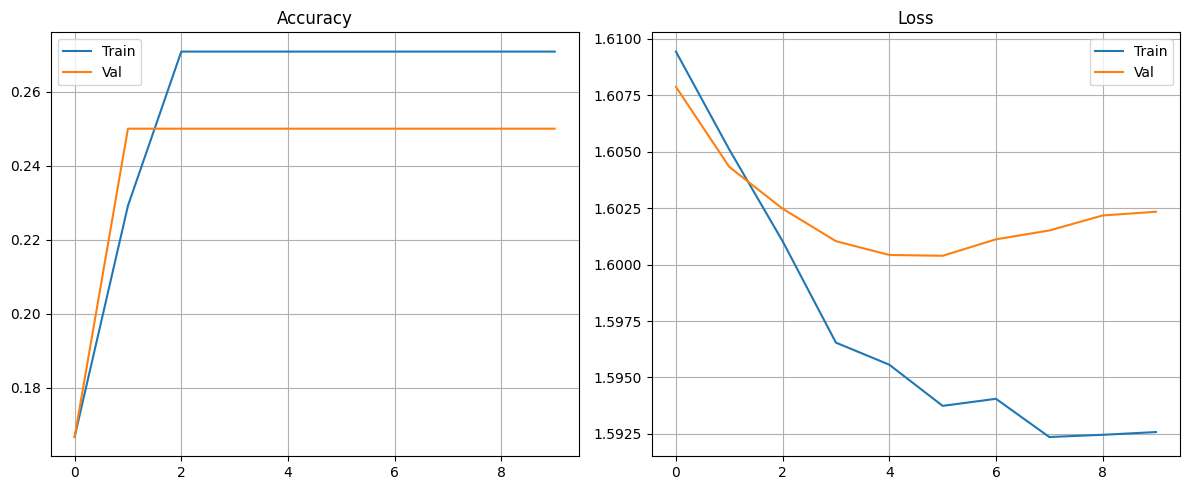

In [30]:
# Accuracy/Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


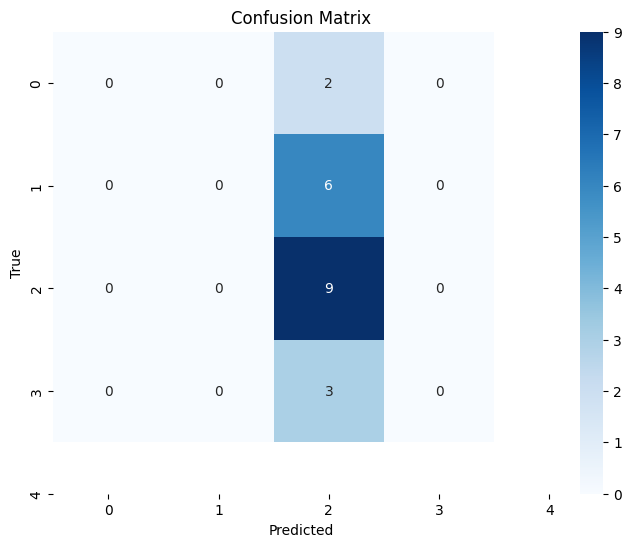

In [31]:
# Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes),
            yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()